<a href="https://colab.research.google.com/github/efrat-dev/ai-code-notebooks/blob/main/02_isolation_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Isolation Forest — full pipeline + auto-sweep of peer-mode/aggregation/calibration/threshold
# pick the best by EMP-VAL (FB with a precision floor), and show all plots/reports.

# imports

In [3]:
import os, re, warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")  # Silence noisy dtype/fragmentation warnings

import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
    f1_score, precision_score, recall_score, confusion_matrix, classification_report, fbeta_score
)
from sklearn.isotonic import IsotonicRegression

# Configuration

In [4]:
OUT_DIR = "IF_peer_relative_top3_output"; os.makedirs(OUT_DIR, exist_ok=True) # Output folder
SEED = 42; np.random.seed(SEED) # Random seed

id_col, dept_col, pos_col = "employee_id", "employee_department", "employee_position"  # Column names
label_col = "is_malicious"  # Action-level label

SAVE_ARTIFACTS = False                    # Also save files in addition to displaying
TOP_N = 30                                # How many top anomalous employees to display
EMPLOYEE_LABEL_RULE = "ratio>=0.2"        # Rule to derive an employee-level label

# Sweep knobs (for tunning)
PEER_MODES = ["dept", "pos", "dp"]        # dept=department, pos=position, dp=dept+position (with backoff dept→global)
AGGREGATORS = ["top3_mean", "top3_median", "top5_trimmed_mean"]  # Per-employee aggregators
CALIBRATION = [False, True]               # Isotonic calibration on VAL
THR_MODES   = ["global", "per_dept"]      # Global or per-department thresholds (coarse)
FBETA_SWEEP = 1.0                         # FB used to choose on VAL
P_MIN_FLOOR = 0.55                        # Precision floor when selecting threshold
MIN_VAL_EMP_PER_DEPT = 8                  # Minimum VAL employees per department
REQUIRE_POS_IN_DEPT = False               # Require positives in VAL per department
COARSEN_SMALL_DEPTS = True                # Coarsen small departments to OTHER_SMALL

# Download from Google Drive


In [5]:
try:
    import gdown
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])
    import gdown

file_ids = {
    'train':   '12p0bNMpieaZ6yoPS-BI71QA_oz7t708i',
    'test':    '18r_G-VF2mjD3ZsGdKOLKFQ6lO5ptSZ_y',
    'val':     '1hShE7wkL0d9BE5AVdKgfV68adyCE_jy5',
    'mapping': '12l2cLI0Efn-WeDmwL8y6v6yyguaNpvQJ'
}
local_files = {
    'train':   'train_processed_lstm.csv',
    'test':    'test_processed_lstm.csv',
    'val':     'val_processed_lstm.csv',
    'mapping': 'mapping_emp_dep_pos.csv'
}
def _download(fid, fn):
    # Download file if missing
    if not os.path.exists(fn):
        gdown.download(f"https://drive.google.com/uc?id={fid}", fn, quiet=False)
for k in ['train','val','test','mapping']:
    _download(file_ids[k], local_files[k])

Downloading...
From (original): https://drive.google.com/uc?id=12p0bNMpieaZ6yoPS-BI71QA_oz7t708i
From (redirected): https://drive.google.com/uc?id=12p0bNMpieaZ6yoPS-BI71QA_oz7t708i&confirm=t&uuid=32d074bf-483b-4a94-8cd1-d7d7ffbb2495
To: /content/train_processed_lstm.csv
100%|██████████| 396M/396M [00:03<00:00, 126MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1hShE7wkL0d9BE5AVdKgfV68adyCE_jy5
From (redirected): https://drive.google.com/uc?id=1hShE7wkL0d9BE5AVdKgfV68adyCE_jy5&confirm=t&uuid=87c21276-cf5a-443f-8828-2961438e89fe
To: /content/val_processed_lstm.csv
100%|██████████| 132M/132M [00:01<00:00, 116MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=18r_G-VF2mjD3ZsGdKOLKFQ6lO5ptSZ_y
From (redirected): https://drive.google.com/uc?id=18r_G-VF2mjD3ZsGdKOLKFQ6lO5ptSZ_y&confirm=t&uuid=b4796e71-432e-4f0c-af4e-c66d1cde5711
To: /content/test_processed_lstm.csv
100%|██████████| 132M/132M [00:02<00:00, 61.7MB/s]
Downloading...
From: https://drive.goog

# Helpers

In [6]:
# Normalize IDs
def _norm(s: pd.Series) -> pd.Series:
    return (s.astype(str)
             .str.replace('\u200f','',regex=False).str.replace('\u200e','',regex=False)
             .str.replace('\xa0',' ',regex=False).str.strip().str.normalize('NFKC')
             .str.replace(r'\.0$', '', regex=True))


# Load data

In [7]:
def load_df(path):
    # Read CSV and normalize employee_id
    df = pd.read_csv(path)
    if id_col in df.columns:
        df[id_col] = _norm(df[id_col])
    return df

def load_mapping(path):
    # Smart read (comma/tab), string dtypes, normalize, enforce 1:1 by employee_id
    m = pd.read_csv(path, sep=None, engine='python', dtype={id_col:str, dept_col:str, pos_col:str})
    for c in [id_col, dept_col, pos_col]:
        if c not in m.columns: raise ValueError(f"Mapping file missing column: {c}")
    m[id_col]  = _norm(m[id_col])
    m[dept_col]= m[dept_col].astype(str).str.strip().replace({'':np.nan,'nan':np.nan,'None':np.nan}).fillna("Unknown")
    m[pos_col] = m[pos_col].astype(str).str.strip().replace({'':np.nan,'nan':np.nan,'None':np.nan}).fillna("Unknown")
    m = m.dropna(subset=[id_col]).drop_duplicates(subset=[id_col], keep='first')
    return m[[id_col, dept_col, pos_col]]

mapping_df = load_mapping(local_files['mapping'])
df_train   = load_df(local_files['train'])
df_val     = load_df(local_files['val'])
df_test    = load_df(local_files['test'])

def safe_merge(df_in, name):
    # Merge mapping + check for blanks
    df = df_in.copy(); n_before = len(df)
    df[id_col] = _norm(df[id_col]); mp = mapping_df.copy(); mp[id_col] = _norm(mp[id_col])
    m = df.merge(mp[[id_col, dept_col, pos_col]], on=id_col, how='left')
    assert len(m)==n_before, f"{name}: merge duplicated rows (before={n_before}, after={len(m)})"
    def _blank(s): return (s.isna() | (s.astype(str).str.strip()=="")).sum()
    b1, b2 = _blank(m[dept_col]), _blank(m[pos_col])
    assert b1==0 and b2==0, f"{name}: empty dept/pos after merge → dept:{b1}, pos:{b2}"
    return m

df_train = safe_merge(df_train, "TRAIN")
df_val   = safe_merge(df_val,   "VAL")
df_test  = safe_merge(df_test,  "TEST")


# Feature selection


## Simple Isolation Forest (V1)

In [18]:
def get_simple_features(df):
    """Select basic numeric features only"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Remove identifiers and labels
    exclude = [id_col, label_col, 'employee_department', 'employee_position']
    for col in exclude:
        if col in numeric_cols:
            numeric_cols.remove(col)

    # Remove engineered features (zscore, quartile, mean, std, median)
    simple_features = []
    for col in numeric_cols:
        if not any(pattern in col.lower() for pattern in ['zscore', 'quartile', '_mean', '_std', '_med']):
            simple_features.append(col)

    return simple_features[:20]  # Keep only first 20 for simplicity

# Select features
simple_feats = get_simple_features(df_train)
print(f"Selected {len(simple_feats)} simple features:")
print(simple_feats[:10], "..." if len(simple_feats) > 10 else "")

# Prepare matrices
X_train_simple = df_train[simple_feats].fillna(0).values
X_val_simple   = df_val[simple_feats].fillna(0).values
X_test_simple  = df_test[simple_feats].fillna(0).values

print(f"Train shape: {X_train_simple.shape}")
print(f"Val shape:   {X_val_simple.shape}")
print(f"Test shape:  {X_test_simple.shape}")

Selected 20 simple features:
['employee_seniority_years', 'num_print_commands', 'total_printed_pages', 'num_printed_pages_off_hours', 'num_color_prints', 'ratio_color_prints', 'num_burn_requests', 'avg_request_classification', 'num_burn_requests_off_hours', 'total_burn_volume_mb'] ...
Train shape: (179928, 20)
Val shape:   (59976, 20)
Test shape:  (59976, 20)


## Improved Isolation Forest (V2)

In [9]:
STATIC_KEYWORDS = [
    'employee_department','employee_position','employee_classification_freq',
    'employee_campus_cat','has_criminal_record','has_medical_history',
    'has_foreign_citizenship','is_contractor','is_employee_in_origin_country',
    'employee_seniority','is_new_employee','is_veteran_employee'
]
EXCLUDE_PATTERNS = [r"_zscore$", r"_quartile$"]

def _is_static(c): return any(k in c for k in STATIC_KEYWORDS)
def _is_excl(c):   return any(re.search(p, c) for p in EXCLUDE_PATTERNS)

def base_feature_candidates(df):
    # Numeric non-static columns, not zscore/quartile
    cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for c in [id_col, label_col]:
        if c in cols: cols.remove(c)
    cols = [c for c in cols if not _is_static(c) and not _is_excl(c)]
    if not cols: raise ValueError("No base features left after filtering.")
    return sorted(cols)

base_feats = base_feature_candidates(df_train)

# Simple Isolation Forest (V1)

## Train

In [19]:
y_train_simple = df_train[label_col].astype(int).values if label_col in df_train.columns else None
y_val_simple = df_val[label_col].astype(int).values if label_col in df_val.columns else None
y_test_simple = df_test[label_col].astype(int).values if label_col in df_test.columns else None

if y_train_simple is not None:
    print(f"Train labels: {np.sum(y_train_simple)}/{len(y_train_simple)} positives")
    print(f"Val labels: {np.sum(y_val_simple)}/{len(y_val_simple)} positives")
    print(f"Test labels: {np.sum(y_test_simple)}/{len(y_test_simple)} positives")

baseline_if = IsolationForest(
    n_estimators=100,
    contamination=0.1,
    random_state=SEED,
    n_jobs=-1
)

baseline_if.fit(X_train_simple)

Train labels: 4864/179928 positives
Val labels: 1219/59976 positives
Test labels: 1438/59976 positives


IsolationForest(contamination=0.1, n_jobs=-1, random_state=42)

## Evaluate baseline model

In [25]:
def get_baseline_scores(X):
    return -baseline_if.score_samples(X)

train_scores = get_baseline_scores(X_train_simple)
val_scores   = get_baseline_scores(X_val_simple)
test_scores  = get_baseline_scores(X_test_simple)

if y_val_simple is not None and y_test_simple is not None:
    # AUC / AP
    print("VAL  - AUC:", roc_auc_score(y_val_simple, val_scores),
          "AP:", average_precision_score(y_val_simple, val_scores))
    print("TEST - AUC:", roc_auc_score(y_test_simple, test_scores),
          "AP:", average_precision_score(y_test_simple, test_scores))

    # threshold: top 10% ב-Val
    thr = np.percentile(val_scores, 90)
    val_pred  = (val_scores  >= thr).astype(int)
    test_pred = (test_scores >= thr).astype(int)

    print("\nVAL REPORT\n",  classification_report(y_val_simple, val_pred, digits=3))
    print("TEST REPORT\n", classification_report(y_test_simple, test_pred, digits=3))
    print("VAL CM:\n",  confusion_matrix(y_val_simple, val_pred))
    print("TEST CM:\n", confusion_matrix(y_test_simple, test_pred))

VAL  - AUC: 0.5336605208283842 AP: 0.024993593995910494
TEST - AUC: 0.5412153968101079 AP: 0.026692560205232793

VAL REPORT
               precision    recall  f1-score   support

           0      0.980     0.901     0.939     58757
           1      0.027     0.132     0.045      1219

    accuracy                          0.885     59976
   macro avg      0.504     0.516     0.492     59976
weighted avg      0.961     0.885     0.921     59976

TEST REPORT
               precision    recall  f1-score   support

           0      0.976     0.908     0.941     58538
           1      0.026     0.100     0.041      1438

    accuracy                          0.889     59976
   macro avg      0.501     0.504     0.491     59976
weighted avg      0.953     0.889     0.919     59976

VAL CM:
 [[52920  5837]
 [ 1058   161]]
TEST CM:
 [[53153  5385]
 [ 1294   144]]


# Improved Isolation Forest (V2)

In [10]:
# TRAIN-only stats
def global_stats(train_df, feat_cols):
    g_mean = train_df[feat_cols].mean().rename(lambda c: f"{c}__g_mean")
    g_std  = train_df[feat_cols].std(ddof=0).replace(0.0, np.nan).rename(lambda c: f"{c}__g_std")
    g_med  = train_df[feat_cols].median().rename(lambda c: f"{c}__g_med")
    return pd.concat([g_mean, g_std, g_med], axis=0)

def dept_stats(train_df, feat_cols):
    g = train_df.groupby(dept_col, observed=True)[feat_cols]
    return pd.concat([g.mean().add_suffix("__d_mean"),
                      g.std(ddof=0).replace(0.0,np.nan).add_suffix("__d_std"),
                      g.median().add_suffix("__d_med")], axis=1).reset_index()

def pos_stats(train_df, feat_cols):
    g = train_df.groupby(pos_col, observed=True)[feat_cols]
    return pd.concat([g.mean().add_suffix("__p_mean"),
                      g.std(ddof=0).replace(0.0,np.nan).add_suffix("__p_std"),
                      g.median().add_suffix("__p_med")], axis=1).reset_index()

def deppos_stats(train_df, feat_cols):
    g = train_df.groupby([dept_col, pos_col], observed=True)[feat_cols]
    return pd.concat([g.mean().add_suffix("__dp_mean"),
                      g.std(ddof=0).replace(0.0,np.nan).add_suffix("__dp_std"),
                      g.median().add_suffix("__dp_med")], axis=1).reset_index()

g_stats0 = global_stats(df_train, base_feats)
d_stats0 = dept_stats(df_train, base_feats)
p_stats0 = pos_stats(df_train, base_feats)
dp_stats0= deppos_stats(df_train, base_feats)

## Peer-relative features

In [11]:
def build_rel_features(df, feat_cols, mode):
    # Compute peer-relative features for the requested mode
    if mode == "dept":
        merged = df.merge(d_stats0, on=dept_col, how="left")
        rel = {}
        for c in feat_cols:
            mean_eff = merged[f"{c}__d_mean"].fillna(g_stats0[f"{c}__g_mean"])
            std_eff  = merged[f"{c}__d_std"] .fillna(g_stats0[f"{c}__g_std"]).replace(0.0, np.nan)
            med_eff  = merged[f"{c}__d_med"] .fillna(g_stats0[f"{c}__g_med"])
            x = df[c]
            rel[f"{c}__diff_grp_mean"] = (x - mean_eff).values
            rel[f"{c}__z_in_grp"]      = ((x - mean_eff) / std_eff).values
            rel[f"{c}__diff_grp_med"]  = (x - med_eff).values
        R = pd.DataFrame(rel, index=df.index).replace([np.inf,-np.inf], np.nan).fillna(0.0)
        X = R.values
        cols = [id_col, dept_col, pos_col] + ([label_col] if label_col in df.columns else [])
        return df[cols].copy(), list(R.columns), X

    if mode == "pos":
        merged = df.merge(p_stats0, on=pos_col, how="left")
        rel = {}
        for c in feat_cols:
            mean_eff = merged[f"{c}__p_mean"].fillna(g_stats0[f"{c}__g_mean"])
            std_eff  = merged[f"{c}__p_std"] .fillna(g_stats0[f"{c}__g_std"]).replace(0.0, np.nan)
            med_eff  = merged[f"{c}__p_med"] .fillna(g_stats0[f"{c}__g_med"])
            x = df[c]
            rel[f"{c}__diff_grp_mean"] = (x - mean_eff).values
            rel[f"{c}__z_in_grp"]      = ((x - mean_eff) / std_eff).values
            rel[f"{c}__diff_grp_med"]  = (x - med_eff).values
        R = pd.DataFrame(rel, index=df.index).replace([np.inf,-np.inf], np.nan).fillna(0.0)
        X = R.values
        cols = [id_col, dept_col, pos_col] + ([label_col] if label_col in df.columns else [])
        return df[cols].copy(), list(R.columns), X

    # mode == "dp": Dept+Pos with backoff to Dept then Global
    merged = df.merge(dp_stats0, on=[dept_col, pos_col], how="left")
    merged = merged.merge(d_stats0, on=dept_col, how="left", suffixes=("", "_donly"))
    rel = {}
    for c in feat_cols:
        mean_eff = merged.get(f"{c}__dp_mean").fillna(merged.get(f"{c}__d_mean")).fillna(g_stats0[f"{c}__g_mean"])
        std_eff  = merged.get(f"{c}__dp_std").fillna(merged.get(f"{c}__d_std")).fillna(g_stats0[f"{c}__g_std"]).replace(0.0, np.nan)
        med_eff  = merged.get(f"{c}__dp_med").fillna(merged.get(f"{c}__d_med")).fillna(g_stats0[f"{c}__g_med"])
        x = df[c]
        rel[f"{c}__diff_grp_mean"] = (x - mean_eff).values
        rel[f"{c}__z_in_grp"]      = ((x - mean_eff) / std_eff).values
        rel[f"{c}__diff_grp_med"]  = (x - med_eff).values
    R = pd.DataFrame(rel, index=df.index).replace([np.inf,-np.inf], np.nan).fillna(0.0)
    X = R.values
    cols = [id_col, dept_col, pos_col] + ([label_col] if label_col in df.columns else [])
    return df[cols].copy(), list(R.columns), X

## Train & row scores


In [12]:
# Train & row scores for a given peer-mode
def train_and_score_for_mode(mode):
    # Build relative features for TRAIN/VAL/TEST per mode, train IF on TRAIN, return row-level scores
    tr_rel, _, Xtr = build_rel_features(df_train, base_feats, mode)
    va_rel, _, Xva = build_rel_features(df_val,   base_feats, mode)
    te_rel, _, Xte = build_rel_features(df_test,  base_feats, mode)
    iso = IsolationForest(n_estimators=300, max_samples="auto", max_features=1.0,
                          bootstrap=False, contamination="auto", random_state=SEED, n_jobs=-1).fit(Xtr)
    def rows(df_rel, X, split):
        raw = iso.score_samples(X); anom = -raw
        out = df_rel[[id_col, dept_col, pos_col]].copy()
        out["if_anomaly_score"] = anom; out["split"] = split
        if label_col in df_rel.columns: out[label_col] = df_rel[label_col].astype(int).values
        return out
    return rows(tr_rel, Xtr, "train"), rows(va_rel, Xva, "val"), rows(te_rel, Xte, "test")

## Per-employee aggregation

In [13]:
def agg_emp(scores, mode):
    # Per-employee aggregators
    a = np.sort(np.asarray(scores))
    if len(a) == 0: return 0.0
    if mode == "top3_median":
        return float(np.median(a[-3:])) if len(a)>=3 else float(np.median(a))
    if mode == "top5_trimmed_mean":
        k = min(5, len(a)); topk = a[-k:];
        if k >= 3: topk = topk[:-1]
        return float(np.mean(topk))
    return float(np.mean(a[-3:])) if len(a)>=3 else float(np.mean(a))  # default top3_mean

def emp_scores_from_rows(rows_df, aggregator):
    # Build per-employee score table from row-level scores
    return (rows_df.groupby(id_col)["if_anomaly_score"]
            .apply(lambda s: agg_emp(s.values, aggregator))
            .reset_index().rename(columns={"if_anomaly_score":"if_employee_score"}))

def build_emp_labels_from_rows(rows_df, rule="ratio>=0.2"):
    # Build employee-level labels from row-level labels
    if label_col not in rows_df.columns: return None
    g = rows_df.groupby(id_col)[label_col].agg(["sum","count"])
    if rule == "any": g["emp_label"] = (g["sum"]>0).astype(int)
    else:
        thr = float(rule.split(">=")[1]) if ">=" in rule else 0.2
        g["emp_label"] = ((g["sum"]/g["count"]) >= thr).astype(int)
    return g["emp_label"].reset_index()

## Thresholding helpers


In [14]:
def pick_threshold(y, s, beta=1.0, p_min=None):
    # Threshold with precision floor
    grid = np.unique(np.quantile(s, np.linspace(0.05, 0.99, 300)))
    best_f, best_t = -1.0, grid[-1]
    for t in grid:
        pred = (s>=t).astype(int)
        if p_min is not None and precision_score(y, pred, zero_division=0) < p_min:
            continue
        f = fbeta_score(y, pred, beta=beta, zero_division=0)
        if f > best_f: best_f, best_t = f, t
    if p_min is not None and best_f < 0: best_t = grid[-1]
    return best_t

def attach_coarse_dept(emp_val_df, emp_test_df):
    # Attach department and coarsen small ones to OTHER_SMALL based on VAL only
    v = emp_val_df.merge(mapping_df[[id_col, dept_col]], on=id_col, how='left')
    t = emp_test_df.merge(mapping_df[[id_col, dept_col]], on=id_col, how='left')
    if not COARSEN_SMALL_DEPTS:
        v["coarse_dept"] = v[dept_col]; t["coarse_dept"] = t[dept_col]; return v,t
    val_counts = v[dept_col].value_counts()
    keep = set(val_counts[val_counts >= MIN_VAL_EMP_PER_DEPT].index.tolist())
    def _coarse(d):
        d = str(d).strip()
        if d not in keep: return "OTHER_SMALL"
        dl = d.lower()
        if "information technology" in dl or dl in {"it","i.t."}: return "INFORMATION TECHNOLOGY"
        if "engineering" in dl: return "ENGINEERING"
        if "hr" in dl or "human resources" in dl: return "HUMAN RESOURCES"
        return d
    v["coarse_dept"] = v[dept_col].map(_coarse); t["coarse_dept"] = t[dept_col].map(_coarse)
    return v, t

def confusion_report(emp_df, name, y_pred):
    # Report + confusion matrix (soft colors)
    y_true = emp_df["emp_label"].astype(int).values
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n[{name}] Classification report:")
    print(classification_report(y_true, y_pred, digits=3))
    print(f"[{name}] Confusion matrix:\n{cm}")
    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    im = ax.imshow(cm, cmap=plt.cm.Blues); cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("count", fontsize=9)
    ax.set_title(f"{name} — Confusion Matrix", fontsize=11)
    ax.set_xticks([0,1], labels=['Pred 0','Pred 1']); ax.set_yticks([0,1], labels=['True 0','True 1'])
    ax.set_xticks(np.arange(-0.5, 2, 1), minor=True); ax.set_yticks(np.arange(-0.5, 2, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
    vmax = cm.max() if cm.size else 1; thresh_c = vmax*0.6
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha='center', va='center', color=('white' if v>thresh_c else '#1a1a1a'),
                fontsize=11, fontweight='bold')
    for sp in ax.spines.values(): sp.set_visible(False)
    plt.tight_layout(); plt.show()

def plot_roc_pr_and_thr(emp_df, name, score_col, chosen_thr):
    # ROC/PR + threshold stability
    y = emp_df["emp_label"].astype(int).values
    s = emp_df[score_col].values
    fpr, tpr, _ = roc_curve(y, s); auc = roc_auc_score(y, s)
    pr, rc, _  = precision_recall_curve(y, s); ap  = average_precision_score(y, s)
    plt.figure(figsize=(6,5)); plt.plot(fpr,tpr,label=f"AUC={auc:.3f}"); plt.plot([0,1],[0,1],'--')
    plt.title(f"ROC — {name} ({score_col})"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout(); plt.show()
    plt.figure(figsize=(6,5)); plt.plot(rc,pr,label=f"AP={ap:.3f}")
    plt.title(f"PR — {name} ({score_col})"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.tight_layout(); plt.show()
    grid = np.unique(np.quantile(s, np.linspace(0.05, 0.99, 60)))
    P,R,F = [],[],[]
    for t in grid:
        pred = (s>=t).astype(int)
        P.append(precision_score(y,pred,zero_division=0))
        R.append(recall_score(y,pred,zero_division=0))
        F.append(f1_score(y,pred,zero_division=0))
    plt.figure(figsize=(10,6))
    plt.plot(grid,P,"--",label="Precision"); plt.plot(grid,R,"--",label="Recall"); plt.plot(grid,F,"--",label="F1")
    if np.isfinite(chosen_thr): plt.axvline(chosen_thr, linestyle=":", label=f"Chosen thr={chosen_thr:.3f}")
    plt.title(f"Threshold Stability — {name} ({score_col})"); plt.xlabel("Threshold"); plt.ylabel("Score")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

## Full auto-sweep

In [15]:
def auto_sweep_and_choose():
    # Sweep all combinations and return the best-by-VAL
    results, best = [], None

    for mode in PEER_MODES:
        # Train & row scores for this peer-mode
        rows_tr, rows_va, rows_te = train_and_score_for_mode(mode)
        # Employee scores for each aggregator
        for agg in AGGREGATORS:
            ev = emp_scores_from_rows(rows_va, agg)
            et = emp_scores_from_rows(rows_te, agg)
            # Employee-level labels
            ev_y = build_emp_labels_from_rows(rows_va, EMPLOYEE_LABEL_RULE)
            et_y = build_emp_labels_from_rows(rows_te, EMPLOYEE_LABEL_RULE)
            if ev_y is None: continue
            ev = ev.merge(ev_y, on=id_col, how='left'); et = et.merge(et_y, on=id_col, how='left')
            # Coarse departments (for per-dept thresholds)
            ev, et = attach_coarse_dept(ev, et)

            for cal in CALIBRATION:
                score_col = "if_employee_score"
                if cal:
                    yv = ev["emp_label"].astype(int).values
                    sv = ev["if_employee_score"].values
                    if yv.min()!=yv.max():
                        iso_cal = IsotonicRegression(out_of_bounds="clip").fit(sv, yv)
                        ev["prob_cal"]  = iso_cal.transform(sv)
                        et["prob_cal"]  = iso_cal.transform(et["if_employee_score"].values)
                        score_col = "prob_cal"
                    else:
                        cal = False  # No label variation > skip

                for tm in THR_MODES:
                    if tm == "global":
                        thr = pick_threshold(ev["emp_label"].astype(int).values,
                                             ev[score_col].values, beta=FBETA_SWEEP, p_min=P_MIN_FLOOR)
                        ev_pred = (ev[score_col].values >= thr).astype(int)
                        et_pred = (et[score_col].values >= thr).astype(int)
                        thr_info = {"global": thr}
                    else: # per_dept
                        thr_map = {}
                        for d, g in ev.groupby("coarse_dept"):
                            if len(g) < MIN_VAL_EMP_PER_DEPT: continue
                            if REQUIRE_POS_IN_DEPT and g["emp_label"].sum()==0: continue
                            y = g["emp_label"].astype(int).values; s = g[score_col].values
                            if y.min()==y.max(): continue
                            thr_map[d] = pick_threshold(y, s, beta=FBETA_SWEEP, p_min=P_MIN_FLOOR)
                        thr_glob = pick_threshold(ev["emp_label"].astype(int).values,
                                                  ev[score_col].values, beta=FBETA_SWEEP, p_min=P_MIN_FLOOR)
                        ev_pred = np.array([1 if v >= thr_map.get(d, thr_glob) else 0
                                            for v,d in zip(ev[score_col].values, ev["coarse_dept"].values)], dtype=int)
                        et_pred = np.array([1 if v >= thr_map.get(d, thr_glob) else 0
                                            for v,d in zip(et[score_col].values, et["coarse_dept"].values)], dtype=int)
                        thr_info = {"per_dept": thr_map, "global_fallback": thr_glob}

                    yv = ev["emp_label"].astype(int).values; yt = et["emp_label"].astype(int).values
                    P_v = precision_score(yv, ev_pred, zero_division=0); R_v = recall_score(yv, ev_pred, zero_division=0)
                    F_v = fbeta_score(yv, ev_pred, beta=FBETA_SWEEP, zero_division=0)
                    P_t = precision_score(yt, et_pred, zero_division=0); R_t = recall_score(yt, et_pred, zero_division=0)
                    F_t = fbeta_score(yt, et_pred, beta=FBETA_SWEEP, zero_division=0)

                    row = dict(peer_mode=mode, aggregator=agg, calibrated=cal, thr_mode=tm, score_col=score_col,
                               P_val=P_v, R_val=R_v, Fbeta_val=F_v, P_test=P_t, R_test=R_t, Fbeta_test=F_t, thr=thr_info)
                    results.append(row)

                    if (best is None) or (F_v > best["Fbeta_val"]) or (F_v==best["Fbeta_val"] and P_v>best["P_val"]):
                        best = row.copy()
                        best["_ev"] = ev.copy(); best["_et"] = et.copy()
                        best["_pred_val"] = ev_pred; best["_pred_test"] = et_pred

    res_df = pd.DataFrame(results).sort_values(["Fbeta_val","P_val"], ascending=[False, False])
    print("\n=== Strategy sweep summary (sorted by Fβ on VAL, then Precision) ===")
    display(res_df.head(20))

    print("\n=== Chosen strategy (by VAL) ===")
    print({k: best[k] for k in ["peer_mode","aggregator","calibrated","thr_mode","score_col","P_val","R_val","Fbeta_val"]})

    confusion_report(best["_ev"],  "EMP VAL (chosen)",  best["_pred_val"])
    confusion_report(best["_et"],  "EMP TEST (chosen)", best["_pred_test"])

    thr_glob = best["thr"].get("global") or best["thr"].get("global_fallback", np.nan)
    plot_roc_pr_and_thr(best["_ev"],  "EMP VAL (chosen)",  best["score_col"], thr_glob)
    plot_roc_pr_and_thr(best["_et"],  "EMP TEST (chosen)", best["score_col"], thr_glob)

    return res_df, best

## Run sweep + final unified scores


=== Strategy sweep summary (sorted by Fβ on VAL, then Precision) ===


,peer_mode,aggregator,calibrated,thr_mode,score_col,P_val,R_val,Fbeta_val,P_test,R_test,Fbeta_test,thr
9,dept,top5_trimmed_mean,False,per_dept,if_employee_score,0.866667,1.000000,0.928571,0.650000,0.764706,0.702703,{'per_dept': {'ENGINEERING': 0.587118668452614...
11,dept,top5_trimmed_mean,True,per_dept,prob_cal,0.923077,0.923077,0.923077,0.833333,0.588235,0.689655,{'per_dept': {'ENGINEERING': 0.022067208154164...
1,dept,top3_mean,False,per_dept,if_employee_score,0.812500,1.000000,0.896552,0.565217,0.764706,0.650000,{'per_dept': {'ENGINEERING': 0.598024653885612...
5,dept,top3_median,False,per_dept,if_employee_score,0.812500,1.000000,0.896552,0.481481,0.764706,0.590909,{'per_dept': {'ENGINEERING': 0.598114787585417...
0,dept,top3_mean,False,global,if_employee_score,0.857143,0.461538,0.600000,0.666667,0.117647,0.200000,{'global': 0.6400966212301764}
2,dept,top3_mean,True,global,prob_cal,0.857143,0.461538,0.600000,0.666667,0.117647,0.200000,{'global': 0.3692586399108014}
8,dept,top5_trimmed_mean,False,global,if_employee_score,0.857143,0.461538,0.600000,0.500000,0.117647,0.190476,{'global': 0.6299723373556777}
10,dept,top5_trimmed_mean,True,global,prob_cal,0.857143,0.461538,0.600000,0.500000,0.117647,0.190476,{'global': 0.38233277591972126}
4,dept,top3_median,False,global,if_employee_score,0.750000,0.461538,0.571429,0.333333,0.117647,0.173913,{'global': 0.6365327421166317}
6,dept,top3_median,True,global,prob_cal,0.750000,0.461538,0.571429,0.333333,0.117647,0.173913,{'global': 0.34473244147157517}



=== Chosen strategy (by VAL) ===
{'peer_mode': 'dept', 'aggregator': 'top5_trimmed_mean', 'calibrated': False, 'thr_mode': 'per_dept', 'score_col': 'if_employee_score', 'P_val': 0.8666666666666667, 'R_val': 1.0, 'Fbeta_val': 0.9285714285714286}

[EMP VAL (chosen)] Classification report:
              precision    recall  f1-score   support

           0      1.000     0.994     0.997       321
           1      0.867     1.000     0.929        13

    accuracy                          0.994       334
   macro avg      0.933     0.997     0.963       334
weighted avg      0.995     0.994     0.994       334

[EMP VAL (chosen)] Confusion matrix:
[[319   2]
 [  0  13]]


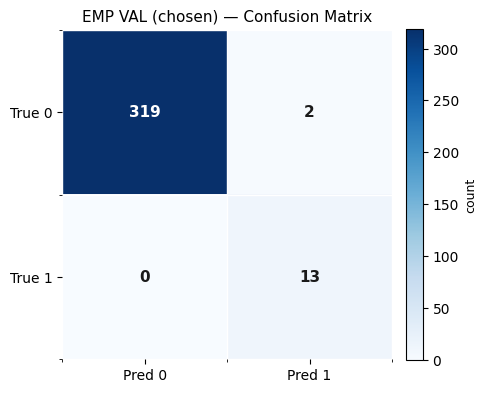


[EMP TEST (chosen)] Classification report:
              precision    recall  f1-score   support

           0      0.987     0.978     0.983       317
           1      0.650     0.765     0.703        17

    accuracy                          0.967       334
   macro avg      0.819     0.871     0.843       334
weighted avg      0.970     0.967     0.968       334

[EMP TEST (chosen)] Confusion matrix:
[[310   7]
 [  4  13]]


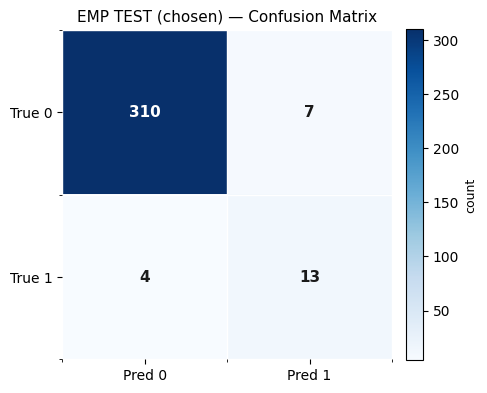

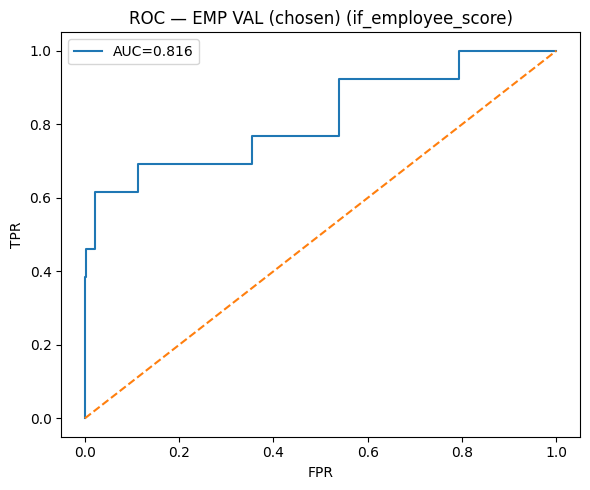

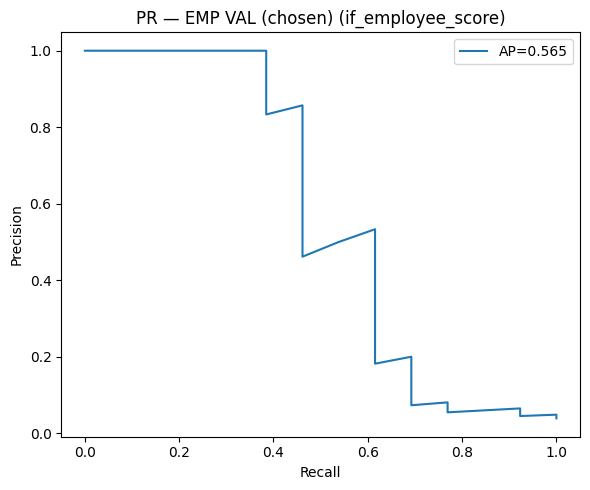

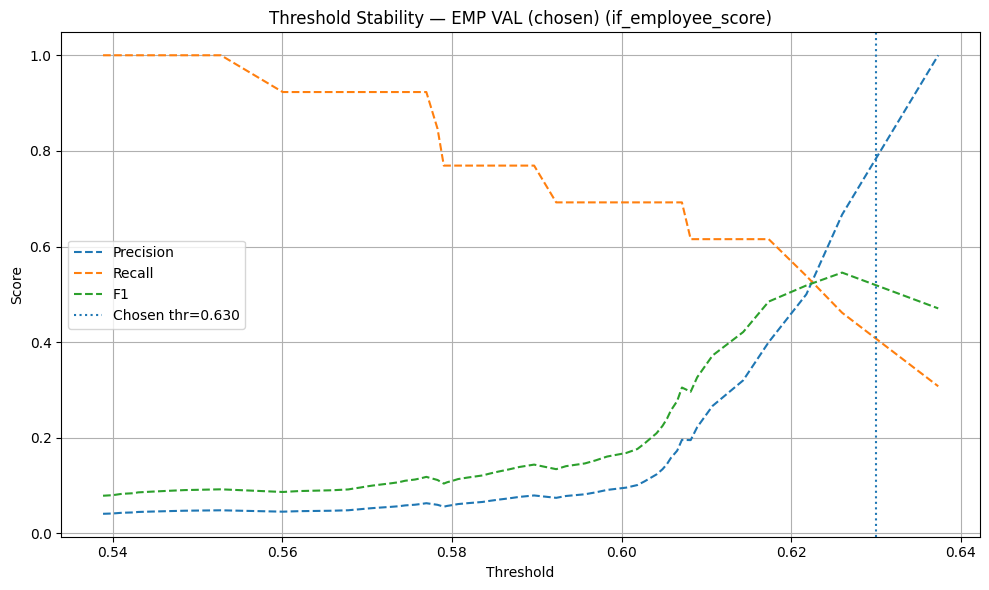

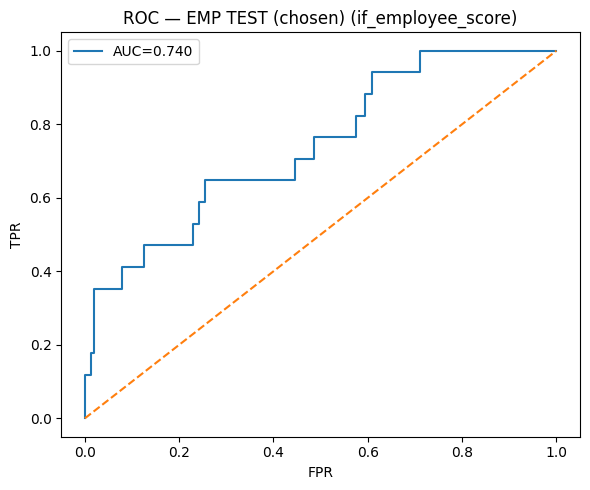

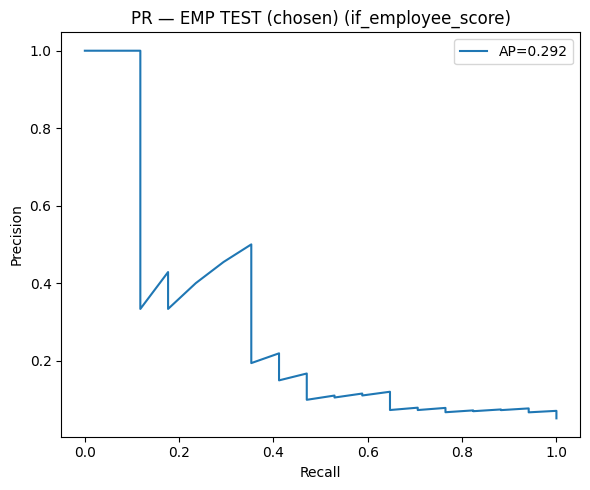

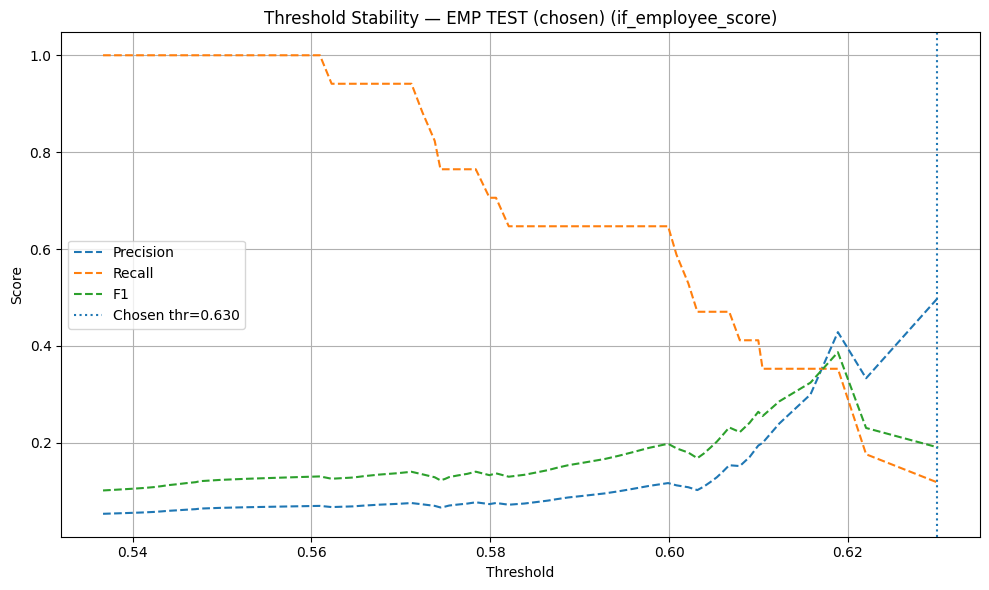


Top-30 anomalous employees (by chosen method):


,employee_id,if_employee_score
1610,949,0.656405
973,375,0.655963
256,1229,0.652794
1663,997,0.651215
1567,91,0.645319
96,1085,0.643523
438,1393,0.642981
294,1263,0.642020
840,255,0.639664
106,1094,0.639566


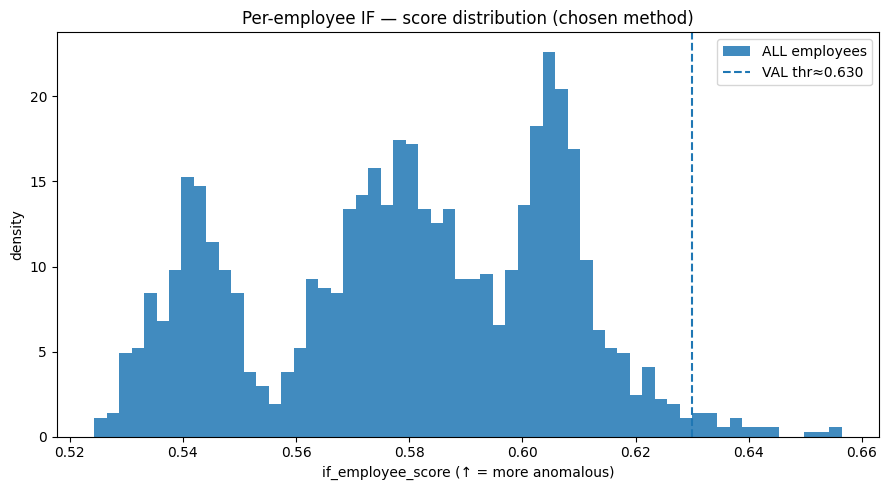


✓ Saved unified employee scores to: IF_peer_relative_top3_output/if_score_per_employee.csv


In [16]:
res_table, best_pick = auto_sweep_and_choose()

# Build unified employee scores using the chosen peer-mode+aggregator across all splits
rows_tr, rows_va, rows_te = train_and_score_for_mode(best_pick["peer_mode"])
emp_train = emp_scores_from_rows(rows_tr, best_pick["aggregator"])
emp_val   = emp_scores_from_rows(rows_va, best_pick["aggregator"])
emp_test  = emp_scores_from_rows(rows_te, best_pick["aggregator"])

emp_all = pd.concat([emp_train, emp_val, emp_test], ignore_index=True)\
           .groupby(id_col, as_index=False)["if_employee_score"].max()

print(f"\nTop-{TOP_N} anomalous employees (by chosen method):")
display(emp_all.sort_values("if_employee_score", ascending=False).head(TOP_N))

# Score histogram + threshold line (if global threshold exists)
plt.figure(figsize=(9,5))
plt.hist(emp_all["if_employee_score"].values, bins=60, density=True, alpha=0.85, label="ALL employees")
chosen_thr = best_pick["thr"].get("global") or best_pick["thr"].get("global_fallback", np.nan)
if np.isfinite(chosen_thr):
    plt.axvline(chosen_thr, linestyle='--', label=f"VAL thr≈{chosen_thr:.3f}")
plt.title("Per-employee IF — score distribution (chosen method)")
plt.xlabel("if_employee_score (↑ = more anomalous)"); plt.ylabel("density")
plt.legend(); plt.tight_layout()
if SAVE_ARTIFACTS: plt.savefig(os.path.join(OUT_DIR, "hist_employee_scores.png"), dpi=130)
plt.show()

# Final CSV — id + score only
final_csv = os.path.join(OUT_DIR, "if_score_per_employee.csv")
emp_all[[id_col, "if_employee_score"]].to_csv(final_csv, index=False)
print("\n✓ Saved unified employee scores to:", final_csv)
